## Reuters with preprocessed dataset

In [2]:
# init
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *
import pandas as pd
from pathlib import Path

FN='../reuters_data/converted_prep.csv'
bs = 32

In [3]:
df = pd.read_csv(FN)

## keep only text and labels
df = df[['text','labels']]
print(len(df))
df.tail()



11351


,text,labels
11346,intervention board detail ec sugar sale london...,88
11347,mead < mea > year dayton corp outlook paper ma...,35
11348,amertek inc < atekf > woodstock ontario profit...,35
11349,brown inc < absb > baltimore <date>shr ct vs c...,35
11350,town country jewelry tcjc > chelsea mass <date...,35


## import pandas_profiling
df['split_labels'] = df.labels.str.split(';')
pandas_profiling.ProfileReport(df)

## Fine-tuning of the language model

In [33]:
data_lm = (TextList.from_csv(Path('.'), FN, cols='text') #, max_vocab=100000, min_freq=2)
           #Inputs: all the text files in path
            # .filter_by_folder(include=['.']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('Reuters_prep_data_lm.pkl')
print('done')

done


In [34]:
data_lm = load_data(Path('.'), 'Reuters_prep_data_lm.pkl', bs=bs)

In [35]:
data_lm.show_batch()

idx,text
0,magazine television cost pct rise revenue fairfax interest group receipt mln capital dividend < associate press pty ltd > xxunk sale xxunk b share reuter < rtrsl > account mln dlr profit fairfax predict result year increase borrowing mln dlr acquisition television station melbourne network channel sydney cost reuter xxbos britoil plc < xxunk > yr p div p vs profit mln profit mln vs mln turnover mln debit mln
1,comecon statement issue talk progress towards position meeting work decision principle relation approval community council minister executive committee comecon xxunk deputy director head bloc delegation reuter today session difference range question comecon insistence joint declaration stipulate berlin community question contain draft side diplomat include clause berlin xxunk agreement talk round trading xxunk september talk union relation ec trade comecon member state xxunk comecon year dlr trade deficit state half deficit
2,york time quote administration official sentiment industry paper quote industry semiconductor computer company newspaper figure opposition japan ltd < itsut > takeover bid < fairchild semiconductor corp > xxunk deal industry analyst move victory administration drive competition computer chip industry official reuter week commerce secretary malcolm defence secretary caspar weinberger fight plan sale xxunk schlumberger ltd < slb > japan computer maker source technology york time baldrige time limit takeover
3,drive concern letter intent exchange pct stock asset hemdale film hemdale entity disclosure sun reevaluate feasibility control company portion share balance xxunk time group plan control company change mind reuter xxbos xxunk inc < xxunk > rd net minneapolis minn profit ct vs loss profit vs loss sale mth shr profit vs loss profit vs loss sale mln vs reuter xxbos americus trust < xxunk > < dividend york <
4,shr ct vs revs mln vs mln avg shr vs reuter xxbos tin pact session week london session tin council itc hold tomorrow < date > member country debate sterling buffer stock price support scheme fail < date > session schedule < date > council pact beyond < date > allow expire year extension reuter xxbos tin council verdict appeal metal trading amt today appeal rule prevent petition tin council


In [36]:
# download pre-trained (Wikipedia) model and create learner
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, wd=0.1)

In [37]:
# test wikidata lang model
TEXT = "The European Commission"
N_WORDS = 40
N_SENTENCES = 4
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The European Commission National Association Competition Commission Report Study Commission Report ) ( July - September ) Rome Police Department General Assembly ( Dutch Republic )
The European Commission European Union case International Trade Commission Commission Commission Inquiry Committee ( VOW ) European Commission Coordination Authority ( FAO ) European Commission
The European Commission Meeting Production Commission Commission Commission Member ( ) Chairman Joseph IV President Jean - Pierre Joseph Du French Pierre Du Nord
The European Commission Summer Council Summer Garden Revival Season One World Tour ( May - August ) ( September ) Paris - Le Bois Paris (


In [38]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


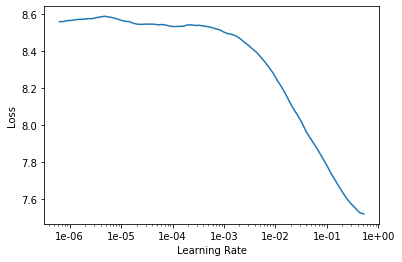

In [39]:
learn_lm.recorder.plot(skip_end=15)

In [40]:
learn_lm.fit_one_cycle(2, 7e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.514505,5.468198,0.285714,00:11
1,4.766319,4.781045,0.314286,00:11


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


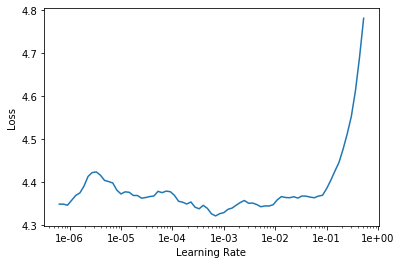

In [42]:
learn_lm.lr_find()
learn_lm.recorder.plot(skip_end=15)

In [43]:
epochs = 10 # orig: 10
learn_lm.fit_one_cycle(epochs, slice(5e-3/(2.6**4), 5e-3) , moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.328074,4.778875,0.300000,00:11
1,4.262118,4.634191,0.328571,00:11
2,4.257793,4.519869,0.328571,00:11
3,4.140695,4.427017,0.342857,00:11
4,4.085331,4.367096,0.342857,00:11
5,3.985366,4.405140,0.328571,00:11
6,3.894646,4.335707,0.328571,00:11
7,3.768609,4.335643,0.328571,00:11
8,3.765850,4.326796,0.328571,00:11
9,3.694419,4.334843,0.328571,00:11


In [44]:
learn_lm.save('fine_tuned-Reuters-prep')
learn_lm.load('fine_tuned-Reuters-prep')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (10216 items)
x: LMTextList
xxbos fairfax tax half < date > medium group john fairfax ltd < xxunk > profit impact change tax system net edge pct mln dlr week end < date > year profit rise pct mln net increase company tax pct imposition tax fringe benefit pay employer company statement fairfax downturn revenue growth television industry reason half consider result view factor fairfax sydney morning herald age advertising volume review post performance magazine television cost pct rise revenue fairfax interest group receipt mln capital dividend < associate press pty ltd > xxunk sale xxunk b share reuter < rtrsl > account mln dlr profit fairfax predict result year increase borrowing mln dlr acquisition television station melbourne network channel sydney cost reuter,xxbos britoil plc < xxunk > yr p div p vs profit mln profit mln vs mln turnover mln debit mln vs operate profit mln vs debit rationalisation programme mln vs petroleum rev

In [47]:
learn_lm.save_encoder('fine_tuned_enc-Reuters-prep')


## Train a classifier

As we are using multi-label classification, we define our own metrics (fastai doesn't support multi-label well yet)

In [48]:
def my_prc(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(pred_pos.sum() + epsilon))#.item()
  
def my_rec(log_preds, targs, thresh=0.5, epsilon=1e-8):
    pred_pos = (log_preds > thresh).float()
    tpos = torch.mul((targs == pred_pos).float(), targs.float())
    return (tpos.sum()/(targs.sum() + epsilon))

thresh=0.001
acc_0001 = partial(accuracy_thresh, thresh=thresh)
prc_0001 = partial(my_prc, thresh=thresh)
rec_0001 = partial(my_rec, thresh=thresh)
f_0001 = partial(fbeta, thresh=thresh, beta=1)


thresh=0.01
acc_001 = partial(accuracy_thresh, thresh=thresh)
prc_001 = partial(my_prc, thresh=thresh)
rec_001 = partial(my_rec, thresh=thresh)
f_001 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.05
acc_005 = partial(accuracy_thresh, thresh=thresh)
prc_005 = partial(my_prc, thresh=thresh)
rec_005 = partial(my_rec, thresh=thresh)
f_005 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.1
acc_01 = partial(accuracy_thresh, thresh=thresh)
prc_01 = partial(my_prc, thresh=thresh)
rec_01 = partial(my_rec, thresh=thresh)
f_01 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.2
acc_02 = partial(accuracy_thresh, thresh=thresh)
prc_02 = partial(my_prc, thresh=thresh)
rec_02 = partial(my_rec, thresh=thresh)
f_02 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.3
acc_03 = partial(accuracy_thresh, thresh=thresh)
prc_03 = partial(my_prc, thresh=thresh)
rec_03 = partial(my_rec, thresh=thresh)
f_03 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.4
acc_04 = partial(accuracy_thresh, thresh=thresh)
prc_04 = partial(my_prc, thresh=thresh)
rec_04 = partial(my_rec, thresh=thresh)
f_04 = partial(fbeta, thresh=thresh, beta=1)

thresh=0.5
acc_05 = partial(accuracy_thresh, thresh=thresh)
prc_05 = partial(my_prc, thresh=thresh)
rec_05 = partial(my_rec, thresh=thresh)
f_05 = partial(fbeta, thresh=thresh, beta=1)


In [49]:
## make small subsample in order to train faster
df = pd.read_csv(FN)
df = df[['text','labels']]


In [51]:
data_clas = (TextList.from_csv(Path('.'), FN, vocab=data_lm.vocab, cols='text')
             #grab all the text files in path
             #wohlg: .split_by_folder(valid='test')
             .split_by_rand_pct()
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)             
             #wohlg: .label_from_folder(classes=['neg', 'pos'])
             .label_from_df(cols='labels', label_delim=';')
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas-prep.pkl')

In [52]:
print(len(data_lm.vocab.itos))
print(data_lm.vocab.itos[:20])

8336
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '>', '<', 'mln', 'reuter', 'date', 'vs', 'year', 'pct', 'dlr', 'share', 'company']


In [53]:
data_clas = load_data(Path('.'), 'data_clas-prep.pkl', bs=bs)

In [56]:
data_clas.show_batch()
#data_clas.label_list


text,target
xxbos detail washington < date > us agriculture department supply demand projection season mln bushel comparison note corn acreage acre plant yield bu supply bu stock production xxunk xinclude import corn cont usage feed ttl dom export total end stock farmer reser stock avgprice bu corn season begin acreage acre plant yield supply bu stck production xinclude import wheat cont usage food seed feed ttl dom export total end stock,103;109;112;113;118;19;42;45;56;59;67;68;81;98
xxbos price boost latin output reuter rio janeiro sugar producer rise world market price move boost production official trade source price rise cent lb month region cent production cost rise price place producer manuel rico consultant group caribbean sugar export country rico cent stimulate increase output producer measure increase production price mexico guatemala ecuador price production industry leader panama costa rica way price mateo vice president costa rica sugar cane,88
xxbos bank spell stephen juke reuter doha < date > bank profit gulf oil state qatar pressure bank xxunk region xxunk market result year decline profit bank operation case cushion drop increase market share < qatar bank xxunk > xxunk manager xxunk xxunk economy hope year bank qatar population xxunk workforce estimate xxunk bank operation banker capital recession year qatar difficulty marketing crude oil official price toll economy bank profitability,30
xxbos computer xxunk < bolster hand lawrence edelman york < date > computer inc mln dlr merger corp < eliminate company competition business machine corp < ibm > wall street analyst ibm force mainframe system software scott analyst donaldson jenrette combination company front computer associate company field analyst terence field segment market system utility software package boost productivity company datum processing facility increase speed power efficiency mainframe computer merger computer,77
xxbos leader challenge era irwin xxunk reuter washington < date > president reagan xxunk nation security market inherit agency insider trading scandal stock price gyration host uncertainty stem market david xxunk law professor university evanston ill name thursday chairman security exchange commission confirm senate john shad agency week record year chairman netherland sec year investigator probe xxunk insider trading scandal street investigation xxunk month number trader investment banking firm charge,77


In [57]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, wd=0.1)
#learn.metrics = [accuracy_thresh, custom_precision, custom_recall, 
#                 acc_01, f_score_01, acc_02, f_score_02, acc_03, f_score_03 ]
learn.metrics = [accuracy_thresh, 
                 acc_0001, prc_0001, rec_0001, f_0001,
                 acc_001, prc_001, rec_001, f_001,
                 acc_005, prc_005, rec_005, f_005,
                 acc_01, prc_01, rec_01, f_01,
                 acc_02, prc_02, rec_02, f_02,
                 acc_03, prc_03, rec_03, f_03,
                 acc_04, prc_04, rec_04, f_04,
                 acc_05, prc_05, rec_05, f_05 ]
#!mv *pth models
learn.load_encoder('fine_tuned_enc-Reuters-prep')


In [58]:
print(learn.loss_func)
print(learn.loss_func.func)

FlattenedLoss of BCEWithLogitsLoss()
BCEWithLogitsLoss()


In [59]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


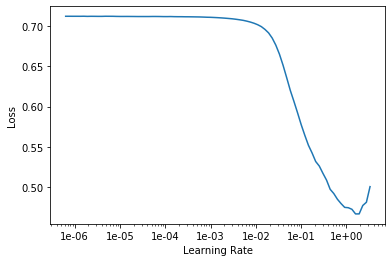

In [60]:
learn.recorder.plot()

In [61]:
learn.fit_one_cycle(2, slice(2e-2,2e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.038606,0.053007,0.988924,0.913394,0.376430,0.061415,0.175766,0.975715,0.376418,0.060619,0.347320,0.986403,0.377182,0.058745,0.356959,0.987673,0.381533,0.057110,0.290194,0.988231,0.382788,0.053076,0.181441,0.988561,0.385227,0.050669,0.132616,0.988702,0.385182,0.047539,0.088563,0.988924,0.394971,0.045555,0.063914,00:08
1,0.025194,0.016118,0.994991,0.718184,0.823912,0.682204,0.123010,0.926820,0.824534,0.681431,0.415094,0.976500,0.833365,0.679576,0.611152,0.986022,0.837620,0.673016,0.682018,0.992000,0.852238,0.662544,0.742978,0.993829,0.866472,0.653884,0.748350,0.994610,0.878205,0.640664,0.734639,0.994991,0.886240,0.628585,0.713181,00:08


In [62]:
learn.save('first-prep')

In [63]:
learn.load('first-prep')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (9081 items)
x: TextList
xxbos fairfax tax half < date > medium group john fairfax ltd < xxunk > profit impact change tax system net edge pct mln dlr week end < date > year profit rise pct mln net increase company tax pct imposition tax fringe benefit pay employer company statement fairfax downturn revenue growth television industry reason half consider result view factor fairfax sydney morning herald age advertising volume review post performance magazine television cost pct rise revenue fairfax interest group receipt mln capital dividend < associate press pty ltd > xxunk sale xxunk b share reuter < rtrsl > account mln dlr profit fairfax predict result year increase borrowing mln dlr acquisition television station melbourne network channel sydney cost reuter,xxbos britoil plc < xxunk > yr p div p vs profit mln profit mln vs mln turnover mln debit mln vs operate profit mln vs debit rationalisation programme mln vs petroleum revenue t

In [64]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


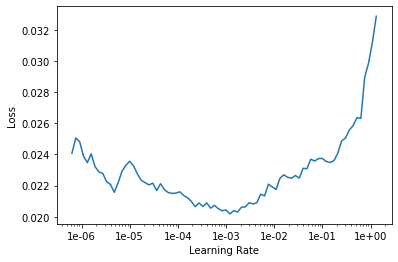

In [65]:
learn.lr_find()
learn.recorder.plot()

In [67]:
learn.fit_one_cycle(4, slice(7e-4/(2.6**4),7e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.023089,0.015211,0.995265,0.726891,0.878461,0.656663,0.102251,0.934324,0.878960,0.656663,0.407500,0.980817,0.883425,0.651054,0.629686,0.989283,0.889020,0.643349,0.710606,0.993696,0.896056,0.632712,0.759537,0.994932,0.903608,0.623272,0.760697,0.995228,0.914932,0.611084,0.735543,0.995265,0.921154,0.599480,0.703581,00:10
1,0.021024,0.014548,0.995439,0.729127,0.874142,0.681433,0.099466,0.936260,0.876189,0.680705,0.410221,0.981387,0.881905,0.677369,0.645453,0.989375,0.887164,0.670768,0.724003,0.993773,0.891778,0.658844,0.772637,0.995050,0.902630,0.649840,0.774597,0.995336,0.909603,0.634117,0.750186,0.995439,0.914763,0.625056,0.724299,00:10
2,0.018741,0.014140,0.995513,0.736294,0.871491,0.693310,0.099812,0.940310,0.872617,0.692555,0.420384,0.982486,0.876888,0.687949,0.663330,0.989831,0.879973,0.679303,0.735940,0.994059,0.890687,0.671146,0.783625,0.995117,0.898680,0.664000,0.779609,0.995428,0.904965,0.649588,0.758028,0.995513,0.911308,0.639809,0.732749,00:10
3,0.019579,0.013969,0.995565,0.747396,0.876872,0.691246,0.107707,0.941313,0.879032,0.690565,0.440886,0.982205,0.885264,0.687170,0.657414,0.989624,0.888756,0.681426,0.732647,0.993947,0.896470,0.668851,0.780974,0.995102,0.901962,0.658323,0.780668,0.995506,0.909229,0.650105,0.763051,0.995565,0.920546,0.639206,0.733490,00:10


In [68]:
learn.save('second-prep')

In [69]:
learn.load('second-prep')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (9081 items)
x: TextList
xxbos fairfax tax half < date > medium group john fairfax ltd < xxunk > profit impact change tax system net edge pct mln dlr week end < date > year profit rise pct mln net increase company tax pct imposition tax fringe benefit pay employer company statement fairfax downturn revenue growth television industry reason half consider result view factor fairfax sydney morning herald age advertising volume review post performance magazine television cost pct rise revenue fairfax interest group receipt mln capital dividend < associate press pty ltd > xxunk sale xxunk b share reuter < rtrsl > account mln dlr profit fairfax predict result year increase borrowing mln dlr acquisition television station melbourne network channel sydney cost reuter,xxbos britoil plc < xxunk > yr p div p vs profit mln profit mln vs mln turnover mln debit mln vs operate profit mln vs debit rationalisation programme mln vs petroleum revenue t

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


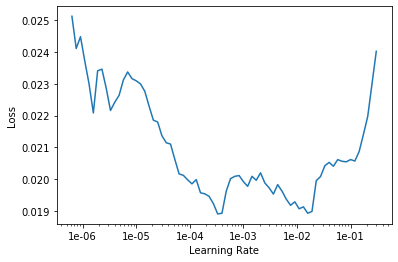

In [70]:
learn.lr_find()
learn.recorder.plot()

In [71]:
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.021039,0.014302,0.995565,0.752582,0.888903,0.682655,0.112745,0.944856,0.889028,0.681104,0.448522,0.984223,0.894123,0.676277,0.673293,0.990501,0.896490,0.672134,0.747924,0.994184,0.909117,0.661270,0.784897,0.995243,0.913535,0.651522,0.783995,0.995558,0.920036,0.642403,0.766516,0.995565,0.929006,0.629664,0.738816,00:10
1,0.018670,0.012487,0.995939,0.803302,0.871759,0.739531,0.155156,0.959457,0.871646,0.738844,0.525036,0.987480,0.875694,0.736080,0.732031,0.992122,0.880172,0.731634,0.782230,0.994788,0.883344,0.722698,0.812013,0.995573,0.889186,0.713986,0.813473,0.995858,0.893540,0.706600,0.796549,0.995939,0.902874,0.699201,0.775376,00:10
2,0.017159,0.011081,0.996316,0.823500,0.891548,0.759971,0.165211,0.962270,0.891372,0.758518,0.559481,0.987521,0.893168,0.755287,0.741398,0.992470,0.894740,0.752062,0.800885,0.995317,0.902945,0.742403,0.833707,0.996117,0.912457,0.732373,0.836663,0.996372,0.922235,0.723498,0.828252,0.996316,0.926049,0.714425,0.803211,00:11


In [72]:
learn.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


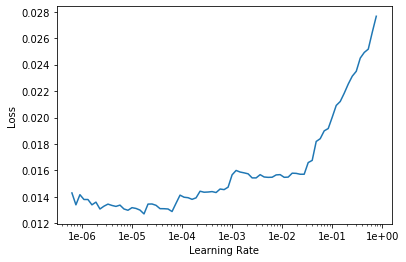

In [73]:
learn.lr_find()
learn.recorder.plot()

In [74]:
learn.fit_one_cycle(5, slice(1e-5/(2.6**4),1e-5), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.016504,0.011197,0.996331,0.821527,0.899252,0.753492,0.171861,0.960445,0.899525,0.753078,0.559187,0.986980,0.900016,0.748686,0.733943,0.992182,0.904879,0.743764,0.793161,0.995336,0.913719,0.733609,0.829907,0.996061,0.919876,0.727403,0.831673,0.996369,0.930040,0.717151,0.818857,0.996331,0.934447,0.702698,0.797714,00:16
1,0.015485,0.011187,0.996339,0.816955,0.888971,0.764956,0.161061,0.960330,0.888861,0.764275,0.546745,0.986866,0.891129,0.761652,0.735705,0.991963,0.895781,0.758335,0.792515,0.995184,0.901117,0.746290,0.831320,0.996006,0.905552,0.735790,0.833687,0.996361,0.912297,0.726504,0.826005,0.996339,0.918260,0.718888,0.804829,00:16
2,0.015845,0.011133,0.996320,0.824895,0.883510,0.768824,0.166467,0.961485,0.884605,0.767039,0.555419,0.987114,0.887137,0.764229,0.738812,0.992108,0.891310,0.758090,0.797697,0.995151,0.898578,0.748639,0.830483,0.995961,0.902723,0.738138,0.833325,0.996368,0.907222,0.729954,0.829649,0.996320,0.912847,0.722301,0.806523,00:15
3,0.014804,0.011165,0.996339,0.812975,0.890255,0.763613,0.156989,0.959893,0.890373,0.761324,0.548765,0.986929,0.892325,0.757983,0.734602,0.992104,0.894826,0.754420,0.795005,0.995243,0.900996,0.743432,0.831704,0.996065,0.907526,0.735673,0.833434,0.996398,0.913732,0.725024,0.828761,0.996339,0.919937,0.713372,0.803493,00:16
4,0.015817,0.011072,0.996320,0.827805,0.882818,0.769675,0.174685,0.961478,0.883683,0.769304,0.563128,0.986899,0.886029,0.765579,0.738401,0.992015,0.889607,0.762158,0.796347,0.995158,0.896183,0.753358,0.831745,0.995965,0.904230,0.743200,0.834792,0.996365,0.910851,0.733547,0.832139,0.996320,0.917111,0.724547,0.806157,00:13


In [75]:
learn.save('third-prep')

In [76]:
learn.load('third-prep');

In [77]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


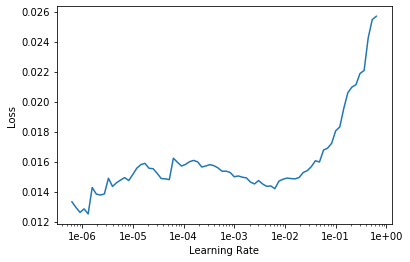

In [78]:
learn.lr_find()
learn.recorder.plot()

In [82]:
learn.fit_one_cycle(15, slice(2e-3/(2.6**4),2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,accuracy_thresh,my_prc,my_rec,fbeta,time
0,0.015847,0.010896,0.996457,0.825854,0.893761,0.772534,0.171735,0.961989,0.893640,0.771330,0.561340,0.987291,0.896675,0.766490,0.742017,0.992241,0.898308,0.762887,0.800830,0.995236,0.902933,0.752167,0.832851,0.996076,0.908092,0.741757,0.839097,0.996465,0.917380,0.733239,0.833305,0.996457,0.923803,0.724104,0.812442,00:16
1,0.014799,0.010390,0.996635,0.824981,0.900997,0.783607,0.168776,0.963325,0.901978,0.782988,0.570756,0.987917,0.903622,0.777435,0.754170,0.992733,0.905808,0.771832,0.811319,0.995524,0.912638,0.763331,0.845323,0.996316,0.919640,0.754651,0.849181,0.996661,0.925316,0.745283,0.842233,0.996635,0.929761,0.732499,0.824301,00:20
2,0.013398,0.009938,0.996739,0.851968,0.902748,0.793698,0.191428,0.967768,0.903636,0.792030,0.602723,0.989172,0.904580,0.789123,0.773130,0.993389,0.909030,0.784699,0.824994,0.995828,0.912552,0.777795,0.855315,0.996413,0.919275,0.769169,0.857106,0.996720,0.923727,0.761440,0.851371,0.996739,0.930023,0.753360,0.835596,00:17
3,0.012805,0.009119,0.997042,0.870048,0.918747,0.806277,0.213288,0.972946,0.919102,0.805349,0.643048,0.991012,0.920974,0.802358,0.799639,0.994495,0.923414,0.798527,0.846468,0.996406,0.928522,0.790422,0.872230,0.996924,0.931339,0.781963,0.874439,0.996990,0.933646,0.772579,0.864560,0.997042,0.940046,0.766464,0.851479,00:17
4,0.010491,0.008689,0.997231,0.884778,0.914433,0.832036,0.239792,0.976856,0.915744,0.832036,0.694934,0.991704,0.917699,0.832036,0.821604,0.994732,0.920171,0.829561,0.862933,0.996257,0.924131,0.822439,0.880910,0.996868,0.927565,0.817390,0.882640,0.997087,0.932961,0.813510,0.874295,0.997231,0.936523,0.807859,0.866633,00:18
5,0.010355,0.008097,0.997442,0.882690,0.933686,0.831060,0.227206,0.979391,0.935093,0.831060,0.706146,0.992940,0.935298,0.829168,0.836940,0.995480,0.937151,0.823916,0.873571,0.996946,0.940468,0.818271,0.892473,0.997327,0.944952,0.812443,0.890014,0.997479,0.947033,0.804986,0.884131,0.997442,0.950360,0.799306,0.873371,00:19
6,0.008933,0.007725,0.997512,0.907419,0.928764,0.844521,0.297822,0.980387,0.928647,0.843065,0.727571,0.992992,0.930414,0.841774,0.844298,0.995498,0.933075,0.841034,0.879547,0.996846,0.937637,0.835580,0.896011,0.997376,0.942170,0.831370,0.900005,0.997497,0.944204,0.822673,0.893571,0.997512,0.950296,0.817399,0.883507,00:18
7,0.008575,0.007326,0.997720,0.923059,0.937884,0.856304,0.337586,0.984411,0.938099,0.856304,0.764091,0.994262,0.938556,0.853838,0.865833,0.996150,0.940000,0.852258,0.893094,0.997235,0.943311,0.847465,0.906839,0.997597,0.947346,0.840624,0.907664,0.997746,0.948977,0.835352,0.904802,0.997720,0.950746,0.828580,0.897088,00:19
8,0.008093,0.006972,0.997775,0.922985,0.942974,0.855705,0.326272,0.985596,0.943263,0.854966,0.779180,0.994758,0.944146,0.853936,0.876832,0.996490,0.944240,0.851690,0.899478,0.997460,0.947771,0.848531,0.912693,0.997779,0.950569,0.844320,0.914119,0.997827,0.954467,0.838071,0.906390,0.997775,0.956312,0.833127,0.896955,00:18
9,0.007735,0.006915,0.997831,0.927827,0.938407,0.866490,0.338963,0.986229,0.938407,0.866490,0.785323,0.994962,0.939669,0.864142,0.879668,0.996550,0.940001,0.862727,0.901334,0.997427,0.942610,0.859482,0.914201,0.997753,0.944824,0.856220,0.914758,0.997827,0.948204,0.852713,0.910527,0.997831,0.950254,0.847312,0.903617,00:16


In [83]:
learn.save('final-prep')

In [84]:
print('done')

done


## Evaluate the results
Based on: https://www.kaggle.com/nadjetba/text-to-meaning-with-multi-label-classification?scriptVersionId=12686831

In [85]:
y_pred, y_true =  learn.get_preds()

In [86]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report

In [91]:
thresh = 0.40

print("F1 (micro)", f1_score(y_true, y_pred>thresh, average='micro'))
print("P (micro)", precision_score(y_true, y_pred>thresh, average='micro'))
print("R (micro)", recall_score(y_true, y_pred>thresh, average='micro'))

print("\nF1 (macro)", f1_score(y_true, y_pred>thresh, average='macro'))
print("P (macro)", precision_score(y_true, y_pred>thresh, average='macro'))
print("R (macro) ", recall_score(y_true, y_pred>thresh, average='macro'))


F1 (micro) 0.8991520837091828
P (micro) 0.9209164818920916
R (micro) 0.8783926683115968

F1 (macro) 0.3867988959711671
P (macro) 0.42948176777358954
R (macro)  0.3661823446042939


In [92]:
f1_score(y_true, y_pred>thresh, average='macro')

0.3867988959711671

In [93]:
y_true_n = y_true.numpy()
scores = y_pred.numpy()
scores.shape, y_true_n.shape

((2270, 119), (2270, 119))

In [94]:
## precision at k
def tmp_precision(actual, predicted):
    #print(predicted)
    actual_one = np.where(actual == 1)[0]
    #print(actual_one)
    #print(type(actual_one))
    
    act_set = set(list(actual_one))
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    return result

def tmp_recall(actual, predicted):
    actual_one = np.where(actual == 1)[0]
    
    act_set = set(actual_one)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(len(act_set))
    return result

## sort indizes in descending order
scores_idx_sorted = (-scores).argsort() 
    
#print(precs)
for i in range(7):
    k = i+1
    
    precs, recas = [], []
    for i in range(len(y_true_n)):
        precs.append( tmp_precision(y_true_n[i], scores_idx_sorted[i]) )
        recas.append( tmp_recall(y_true_n[i], scores_idx_sorted[i]) )
    
    print("Precision at: %d:   " % (k,), sum(precs)/len(precs))
    print("Recall at: %d:   " % (k,), sum(recas)/len(recas))
    print()

Precision at: 1:    0.9462555066079296
Recall at: 1:    0.8617963778756731

Precision at: 2:    0.5519823788546255
Recall at: 2:    0.9437469407733725

Precision at: 3:    0.3845814977973677
Recall at: 3:    0.9635812180966364

Precision at: 4:    0.2954845814977974
Recall at: 4:    0.9743717222571849

Precision at: 5:    0.23982378854625014
Recall at: 5:    0.9805838752534789

Precision at: 6:    0.2014684287812101
Recall at: 6:    0.9844056359695126

Precision at: 7:    0.17363121460038433
Recall at: 7:    0.9866292566953359



In [95]:
metrics = classification_report(y_true_n, scores>thresh, target_names=data_clas.valid_ds.classes)
print(metrics)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         4
         100       0.00      0.00      0.00         0
         101       0.00      0.00      0.00         2
         102       1.00      0.50      0.67         2
         103       0.50      0.50      0.50         4
         104       0.00      0.00      0.00         0
         105       0.00      0.00      0.00         1
         106       0.83      0.77      0.80        13
         107       1.00      0.80      0.89         5
         108       1.00      0.50      0.67         2
         109       0.90      0.82      0.86        11
          11       0.00      0.00      0.00         0
         110       0.67      0.50      0.57         4
         111       0.00      0.00      0.00         1
         112       0.88      0.58      0.70        12
         113       0.69      0.83      0.76        30
         114       0.91    

/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/wohlg/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
